In [1]:
from qiskit import *

In [2]:
from qiskitHODL import*

In [3]:
qr = QuantumRegister(name="reg1", size=3)

In [4]:
oracle = compile_oracle("""
function hodl_oracle(super a, int b) {
    if(a > b) {
        mark(a,pi);
    }
}
""")

In [5]:
from qiskit import QuantumCircuit
circ = oracle.to_circ([qr,5])
qc = QuantumCircuit(circ.num_qubits, qr.size)
qc.h(range(3))
qc.compose(circ,range(circ.num_qubits), inplace=True)
qc.h(range(3))
qc.x(range(3))
qc.h(2)
qc.ccx(0,1,2)
qc.h(2)
qc.x(range(3))
qc.h(range(3))
qc.measure(range(3), range(3))

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


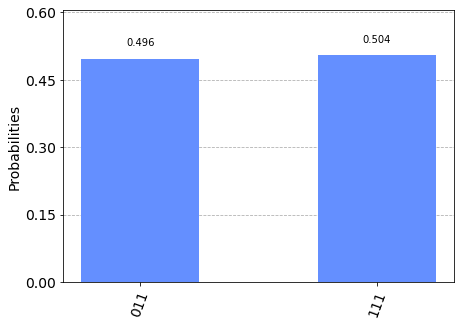

In [6]:
def runq(circuit):
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub = 'ibm-q')
    device = provider.get_backend('ibmq_qasm_simulator')
    job = execute(circuit,backend = device,shots = 1024)
    return job.result()

res = runq(qc)
plot_histogram(res.get_counts())